<h1 style="font-size: 1.6rem; font-weight: bold">ITO 5047: Fundamentals of Artificial Intelligence</h1>
<h1 style="font-size: 1.6rem; font-weight: bold">Machine Learning Methods: Naïve Bayes (Gaussian Exercise)</h1>
<p style="margin-top: 5px; margin-bottom: 5px;">Monash University Australia</p>
<p style="margin-top: 5px; margin-bottom: 5px;">Jupyter Notebook by: Tristan Sim Yook Min</p>
References: Information Source from Monash Faculty of Information Technology

---


### **Python Exercise: Naive Bayes (Gaussian - Machine Predictive Maintenance Classification)**

Gaussian Naive Bayes is ideal for predictive maintenance using continuous sensor readings like temperature, vibration levels, pressure, or RPM. For example, it learns that failing machines typically have vibration levels around 85±10 Hz and temperature around 95±5°C, while healthy machines show 45±8 Hz and 70±3°C, then classifies whether a machine needs maintenance based on where its current sensor readings fall within these distributions.

The Example Below shows the Machine Predictive Maintenance Classification Dataset from Kaggle.

#### **1) Dataset Information**

##### **Machine Predictive Maintenance Classification Dataset**

A synthetic dataset reflecting real industrial predictive maintenance scenarios with **10,000 data points** and **14 features**.

| Feature | Description | Details |
|---------|-------------|---------|
| **UID** | Unique identifier | Range: 1 to 10,000 |
| **Product ID** | Product quality variant + serial number | L (Low - 50%), M (Medium - 30%), H (High - 20%) |
| **Air Temperature [K]** | Ambient temperature | Random walk, σ = 2K, centered at 300K |
| **Process Temperature [K]** | Operating temperature | Air temp + 10K, σ = 1K |
| **Rotational Speed [rpm]** | Shaft rotation speed | Calculated from 2860W power with noise |
| **Torque [Nm]** | Applied torque | Normal distribution: μ = 40Nm, σ = 10Nm (no negatives) |
| **Tool Wear [min]** | Cumulative tool usage | H/M/L variants add 5/3/2 minutes respectively |

##### **Targets**

| Target | Description |
|--------|-------------|
| **Target** | Binary: Failure or Not |
| **Failure Type** | Categorical: Type of failure |

**Critical Warning**: Both are targets so **do not use one as a feature** to avoid data leakage!

**Data leakage** occurs when information from outside the training dataset (or from the target itself) is used to create the model, artificially inflating performance. The model appears highly accurate during training/testing but fails in real-world deployment because the leaked information isn't available when making actual predictions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn.preprocessing     # Preparing & Transforming Data before Training
import sklearn.model_selection   # Splitting & Validating Dataset
import sklearn.naive_bayes       # Naive Bayes Classification Algorithm
import sklearn.metrics           # Evaluating Model Metrics

# Load the Dataset Downloaded from Kaggle: Machine Predictive Maintenance Classification
# Link: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
file_path = os.path.join("resources","datasets","predictive_maintenance.csv")

# Create Data Frame to Store the CSV Data
pred_maint_df = pd.read_csv(file_path)

# Print the Dataset Information
print(f"Dataset Shape: {pred_maint_df.shape}")
print(f"Columns: {pred_maint_df.columns.to_list()}")
print(f"\nFirst 5 Rows of Data:")
display(pred_maint_df.head())

# Data Set Information
total_num_of_data = len(pred_maint_df)
print(f"\nTotal Number of Records: {total_num_of_data}")

Dataset Shape: (10000, 10)
Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']

First 5 Rows of Data:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



Total Number of Records: 10000


#### **2) Explore the Dataset**

Target Distribution (Binary Failure):


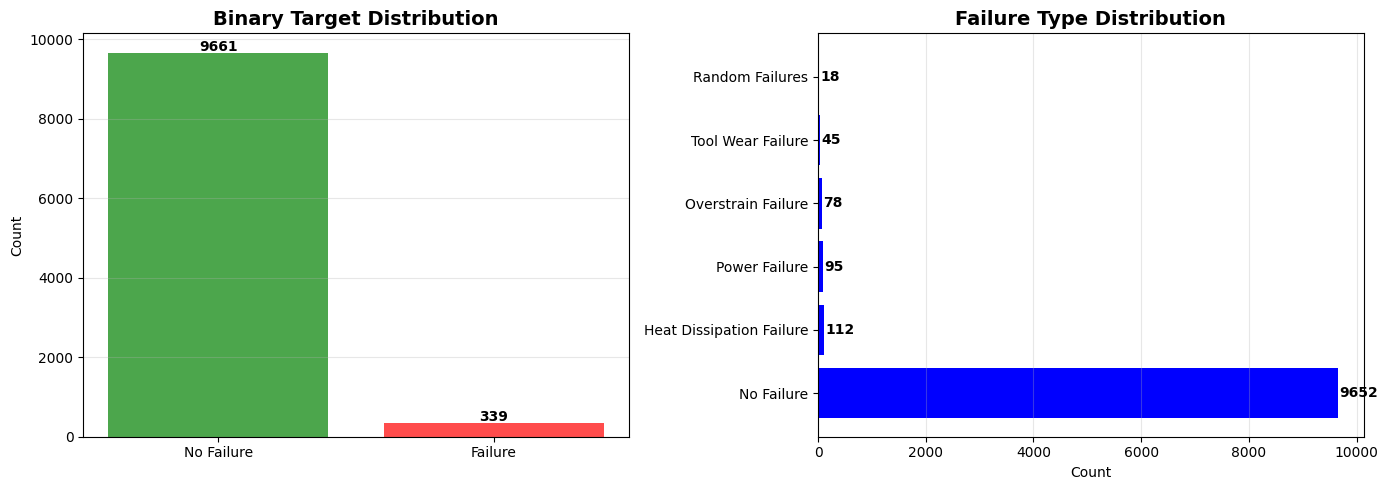

In [14]:
# Target Distribution (Count the Number of '0' - No Failures and '1' - Failures)
print("Target Distribution (Binary Failure):")
target_distribution_df = pred_maint_df['Target'].value_counts()
failure_type_distribution = pred_maint_df['Failure Type'].value_counts()
failure_rate = pred_maint_df['Target'].mean() * 100

# Create a Plot
figure, axes = plt.subplots(1, 2, figsize = (14, 5))

# Binary Target Distribution Plot
axes[0].bar(['No Failure', 'Failure'], target_distribution_df.values, color = ['green', 'red'], alpha = 0.7)
axes[0].set_title('Binary Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, j in enumerate(target_distribution_df.values):
    axes[0].text(i, j + 50, str(j), ha='center', fontweight='bold')

# Failure Types Distribuion Plot
axes[1].barh(failure_type_distribution.index, failure_type_distribution.values, color='blue')
axes[1].set_title('Failure Type Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].grid(axis='x', alpha=0.3)
for i, j in enumerate(failure_type_distribution.values):
    axes[1].text(j + 20, i, str(j), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

#### **3) Feature Analysis: Check for Normal Distribution**

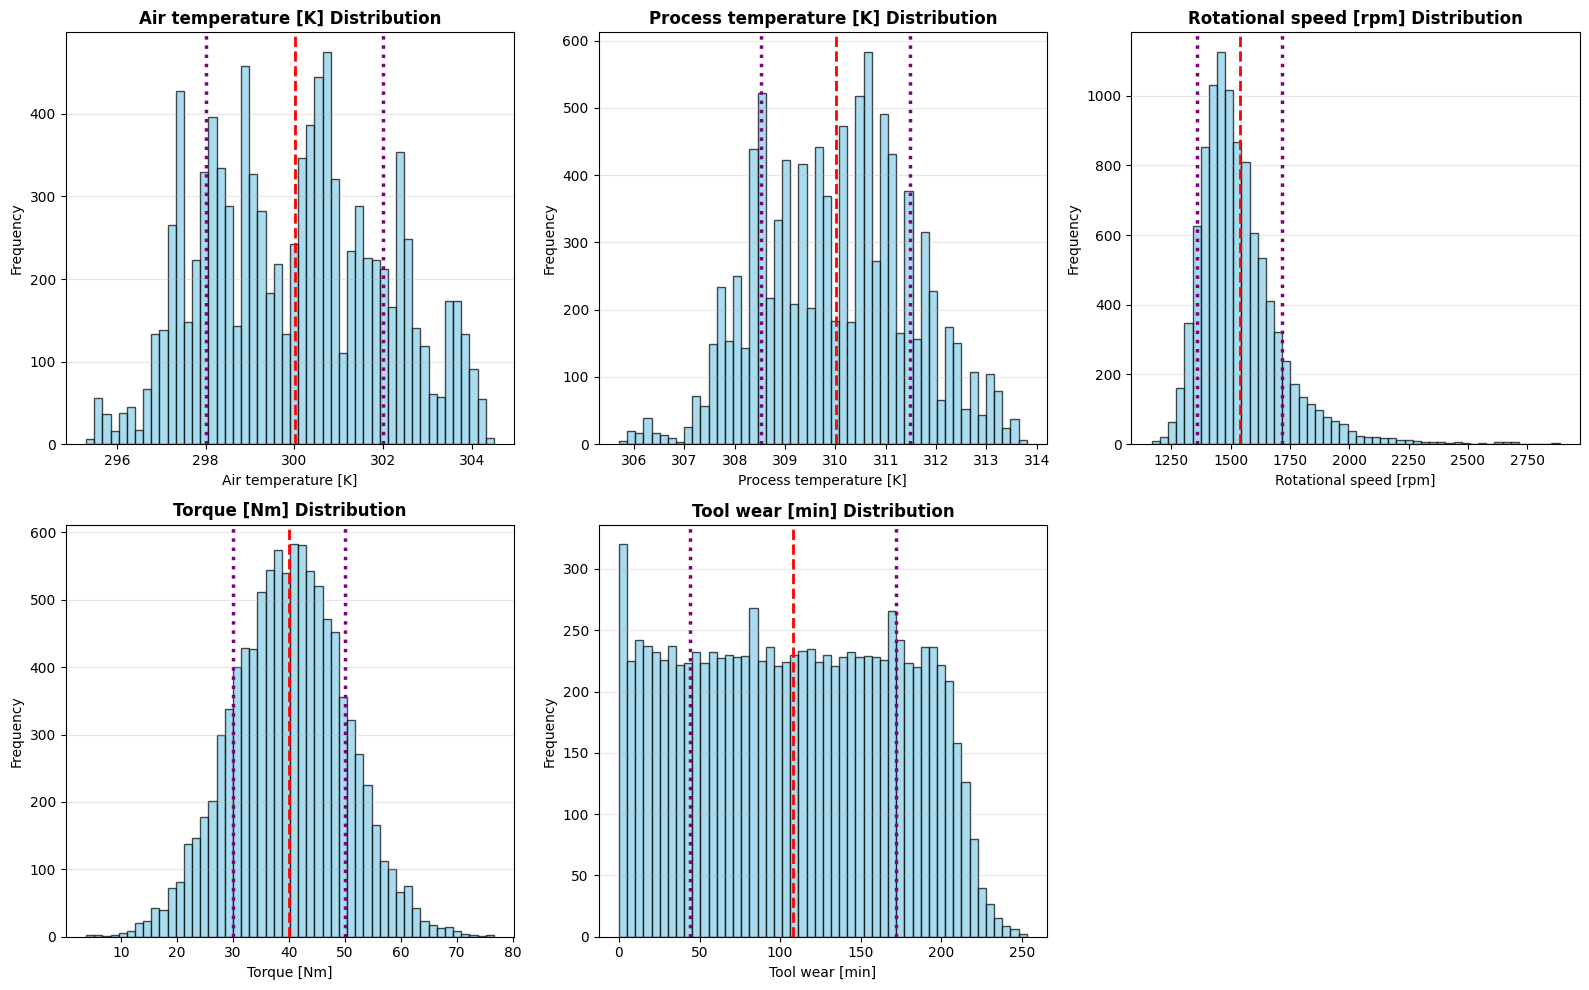

In [20]:
# Select Continuous Features
continuous_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Plot Distributions
figure, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    # Histogram with Kernel Density Estimation (Makes Choppy Histogram creates a Smooth Curve)
    axes[i].hist(pred_maint_df[feature], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Mean and Standard Deviation Lines
    mean_val = pred_maint_df[feature].mean()
    std_val = pred_maint_df[feature].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='purple', linestyle=':', linewidth=2.5, label=f'±1 STD')
    axes[i].axvline(mean_val - std_val, color='purple', linestyle=':', linewidth=2.5)

figure.delaxes(axes[5]) # Remove extra subplot
plt.tight_layout()
plt.show()


| Feature | Distribution Quality | Mean | Spread | Shape Description | Insight | GNB Suitability |
|---------|---------------------|------|--------|-------------------|---------|-----------------|
| **Air Temperature [K]** | Good | ~300K (27°C) | ±2K (Tight) | Nearly perfect bell curve (normal distribution) | Very stable operating temperature, minimal variation |  Perfect with Gaussian assumptions |
| **Process Temperature [K]** | Good | ~310K (37°C) | ±2K (Tight) | Good normal distribution | Process runs ~10K hotter than ambient, well-controlled | Perfect bell curve = ideal for Gaussian NB |
| **Rotational Speed [rpm]** | Decent | ~1500 rpm | ±200 rpm (Moderate) | Mostly normal, slightly left-skewed | Most operations cluster around 1500 rpm, some slower speeds | Still works well, close enough to normal distribution |
| **Torque [Nm]** | Excellent | ~40 Nm | ±10 Nm (Good) | Classic bell curve (textbook normal distribution) | Well-balanced torque distribution, centered operation | Best distribution in the dataset! |
| **Tool Wear [min]** | Problematic | ~108 min | Very wide | Not normal due to flat distribution | Tool wear evenly distributed 0-250 min (machines at all wear stages) | Violates Gaussian assumption but GNB often works anyway |

#### **4) Feature Correlation Analysis**

Naive Bayes assumes feature independence and a High Correlation between Features may affect performance based on the **Pearson Correlation Coefficient Formula** as shown below:

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \times \sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

Where:
- $r$ = correlation coefficient (-1 to +1)
- $x_i, y_i$ = individual data points for variables X and Y
- $\bar{x}, \bar{y}$ = mean values of X and Y
- $\sum$ = sum of all values
- $n$ = number of data points

<br>

| Correlation Value | Interpretation | Impact on Naive Bayes |
|-------------------|----------------|----------------------|
| 0.0 to ±0.3 | Weak/No correlation | Independent - Great for NB |
| ±0.3 to ±0.7 | Moderate correlation | Somewhat dependent - NB still works |
| ±0.7 to ±1.0 | Strong correlation | Highly dependent - Violates NB assumption |

Correlation Matrix:


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


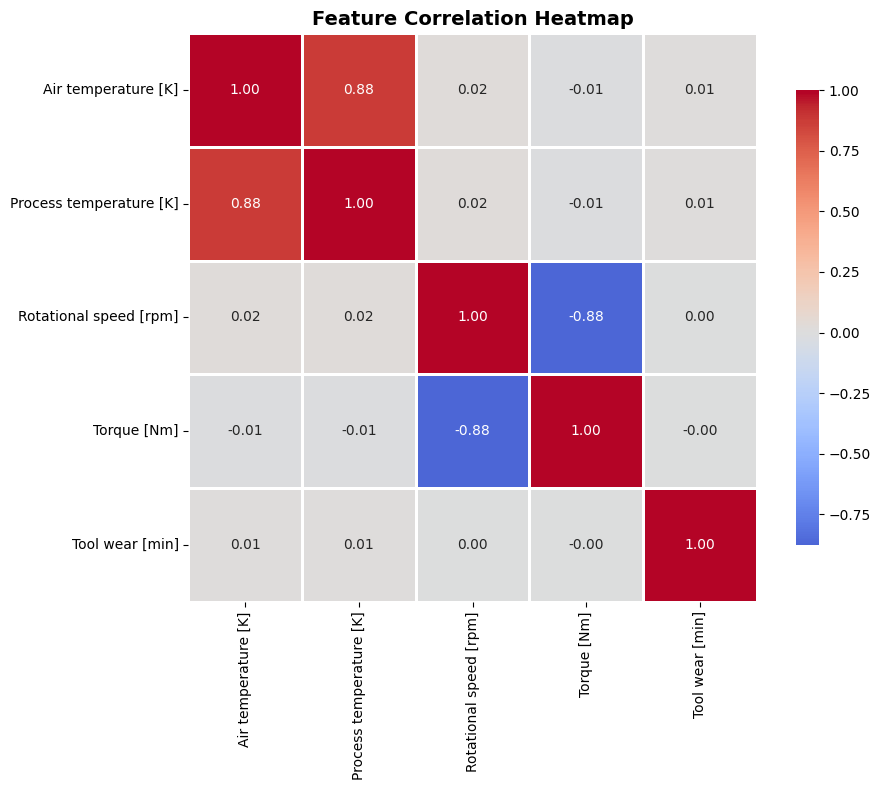

In [22]:
# Correlation matrix
correlation_matrix = pred_maint_df[continuous_features].corr()
print("Correlation Matrix:")
display(correlation_matrix)

# Visualize correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### **5) Feature Comparison: Failure vs No Failure**

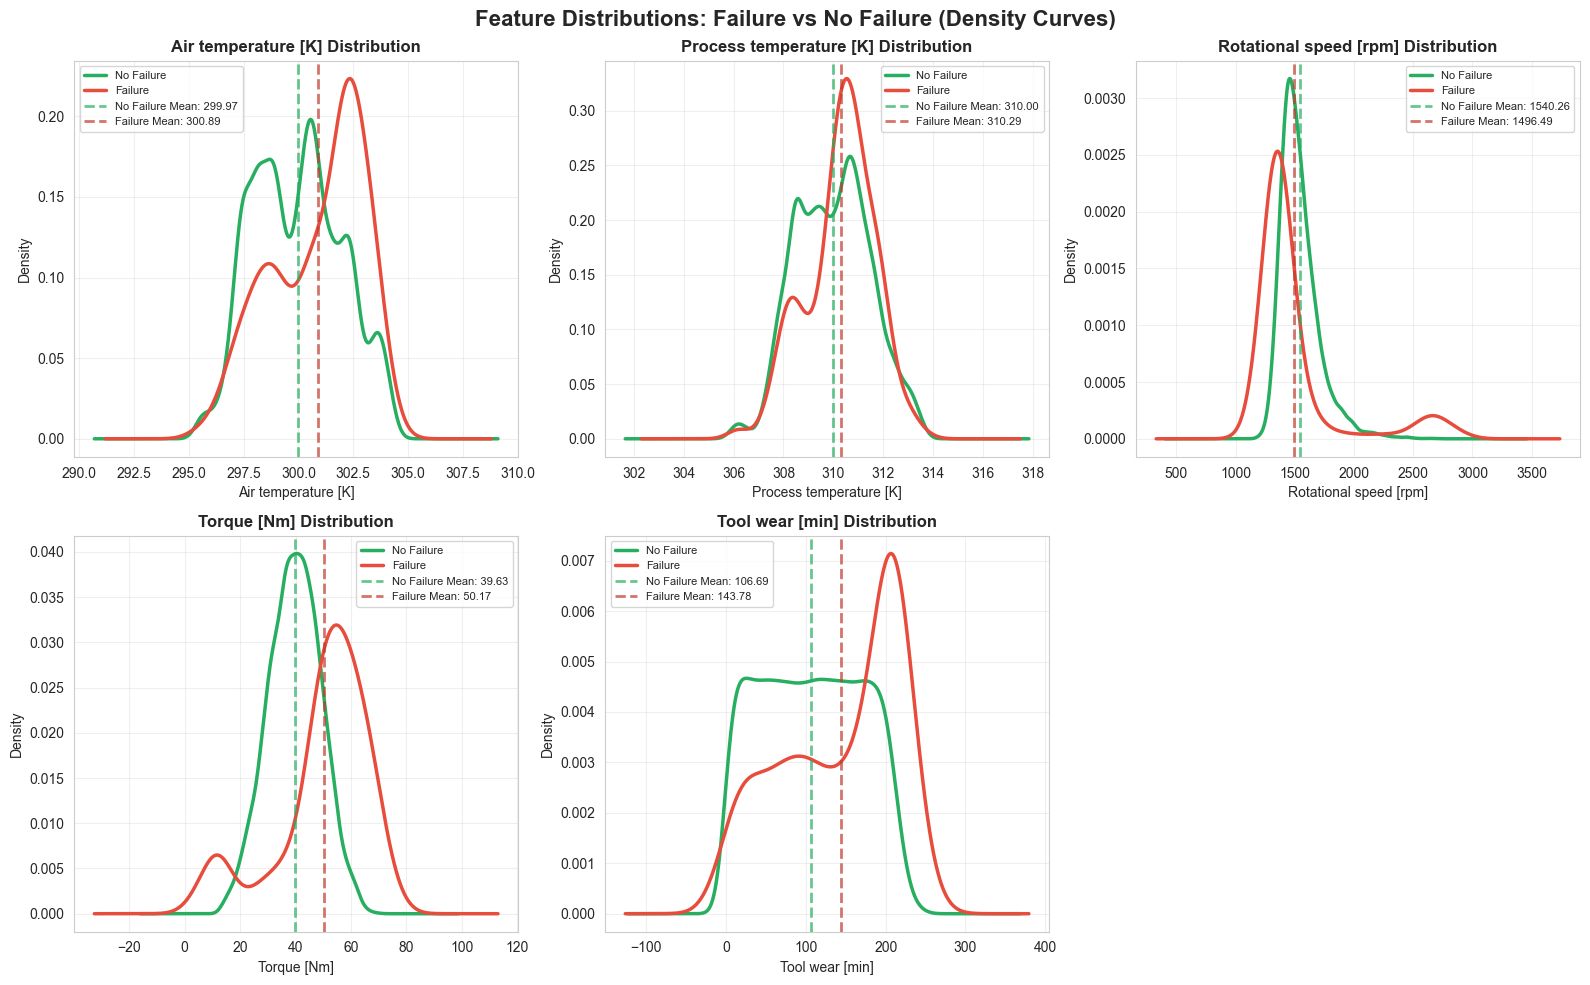

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    
    # Separate data
    no_failure = pred_maint_df[pred_maint_df['Target'] == 0][feature]
    failure = pred_maint_df[pred_maint_df['Target'] == 1][feature]
    
    # Plot KDE curves
    no_failure.plot(kind='density', ax=axes[i], label='No Failure', color='#27ae60', linewidth=2.5)
    failure.plot(kind='density', ax=axes[i], label='Failure', color='#e74c3c', linewidth=2.5)
    
    # Add mean lines
    axes[i].axvline(no_failure.mean(), color='#27ae60', linestyle='--', linewidth=2, alpha=0.7, label=f'No Failure Mean: {no_failure.mean():.2f}')
    axes[i].axvline(failure.mean(), color='#c0392b', linestyle='--', linewidth=2, alpha=0.7, label=f'Failure Mean: {failure.mean():.2f}')
    axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

fig.delaxes(axes[5])
plt.suptitle('Feature Distributions: Failure vs No Failure (Density Curves)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


#### **6) Prepare Training and Test Data**

In [ ]:
# Select features and target
x_data = pred_maint_df[continuous_features]
y_binary = pred_maint_df['Target']               # Binary classification
y_multiclass = pred_maint_df['Failure Type']     # Multi-class classification

# Split data (80/20)
x_train, x_test, y_train_bin, y_test_bin = sklearn.model_selection.train_test_split(x_data, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

x_train_multi, x_test_multi, y_train_multi, y_test_multi = sklearn.model_selection.train_test_split(x_data, y_multiclass,test_size=0.2,random_state=42,stratify=y_multiclass)

print(f"\nTraining Set size: {len(x_train)} samples (80%)")
print(f"Test Set size: {len(x_test)} samples (20%)")


Training Set size: 8000 samples (80%)
Test Set size: 2000 samples (20%)


#### **7) Train Gaussian Naive Bayes (Binary and Multi-Class)**

In [40]:
# Initialize and Train the Model (Binary)
gauss_NB_Binary = sklearn.naive_bayes.GaussianNB()
gauss_NB_Binary.fit(x_train, y_train_bin)
# Make predictions
y_pred_bin = gauss_NB_Binary.predict(x_test)
y_pred_proba_bin = gauss_NB_Binary.predict_proba(x_test)

# Initialize and Train the Model (Multi-Class)
gauss_NB_MultiClass = sklearn.naive_bayes.GaussianNB()
gauss_NB_MultiClass.fit(x_train_multi, y_train_multi)
# Make predictions
y_pred_MultiClass = gauss_NB_Binary.predict(x_test_multi)
y_pred_proba_MultiClass = gauss_NB_Binary.predict_proba(x_test_multi)

print("\nModels trained successfully!")


Models trained successfully!
